In [1]:
'''
Author: Bryan Bo Cao
Email: boca7588@colorado.edu or bo.cao-1@colorado.edu
Github Repo: https://github.com/BryanBo-Cao/neuralnets-deeplearning
Some of the code is modified from "3_mnist_from_scratch from", "docker run -it -p 8888:8888 gcr.io/tensorflow/tensorflow"
'''
from __future__ import print_function

import tensorflow as tf
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from importlib import import_module
from CIFAR_reader import CIFAR_reader # Reference: https://github.com/michael-iuzzolino/CIFAR_reader

In [2]:
cifar = CIFAR_reader(one_hot=True, verbose=True, img_size=32, num_classes=10, augment=False)

Checking for CIFAR data...
Extracting Data...
Unpacking data...
Loading training batch 1 of 5...
Loading training batch 2 of 5...
Loading training batch 3 of 5...
Loading training batch 4 of 5...
Loading training batch 5 of 5...
Loading testing batch 1 of 1...


In [12]:
training_data = cifar.train
training_labels = cifar.labels
train_data = training_data['data']
train_labels = training_data['labels']

testing_data = cifar.test
test_data = testing_data['data']
test_labels = testing_data['labels']

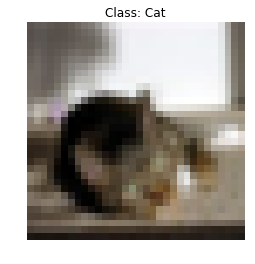

In [13]:
cifar.preview_data(data_set="training")

In [16]:
print (train_data.shape)
print (train_labels.shape)
print (test_data.shape)
print (test_labels.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [6]:
VALIDATION_SIZE = 10000

train_data = train_data[VALIDATION_SIZE:, :, :, :]
train_labels = train_labels[VALIDATION_SIZE:]
validation_data = train_data[:VALIDATION_SIZE, :, :, :]
validation_labels = train_labels[:VALIDATION_SIZE]

print('train_data.shape', train_data.shape)
print('validation_data.shape', validation_data.shape)
print('train_data size:', len(train_data))
print('validation_data size:', len(validation_data))

train_data.shape (40000, 32, 32, 3)
validation_data.shape (10000, 32, 32, 3)
train_data size: 40000
validation_data size: 10000


In [20]:
import tensorflow as tf

IMAGE_SIZE = 32
PIXEL_DEPTH = 255
BATCH_SIZE = 100
N_CHANNELS = 1
N_LABELS = 10
SEED = 32

train_data_node = tf.placeholder(
  tf.float32,
  shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS))
train_labels_node = tf.placeholder(tf.float32,
                                   shape=(BATCH_SIZE, N_LABELS))

validation_data_node = tf.constant(validation_data)
test_data_node = tf.constant(test_data)

conv1_weights = tf.Variable(
  tf.truncated_normal([5, 5, N_CHANNELS, 32],  # 5x5 filter, depth 32.
                      stddev=0.1,
                      seed=SEED))
conv1_biases = tf.Variable(tf.zeros([32]))
conv2_weights = tf.Variable(
  tf.truncated_normal([5, 5, 32, 64],
                      stddev=0.1,
                      seed=SEED))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64]))
fc1_weights = tf.Variable(  # fully connected, depth 512.
  tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
                      stddev=0.1,
                      seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))
fc2_weights = tf.Variable(
  tf.truncated_normal([512, N_LABELS],
                      stddev=0.1,
                      seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[N_LABELS]))

print('Variables Initialized')

Variables Initialized


In [22]:
def model(data, train=False):
    """The Model definition."""
    # 2D convolution, with 'SAME' padding (i.e. the output feature map has
    # the same size as the input). Note that {strides} is a 4D array whose
    # shape matches the data layout: [image index, y, x, depth].
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')

    # Bias and rectified linear non-linearity.
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))

    # Max pooling. The kernel size spec ksize also follows the layout of
    # the data. Here we have a pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

    # Reshape the feature map cuboid into a 2D matrix to feed it to the
    # fully connected layers.
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
  
    # Fully connected layer. Note that the '+' operation automatically
    # broadcasts the biases.
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)

    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
        hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

print('Model defined')

Model defined
